In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import socket

import rclpy
from rclpy.node import Node
from cv_bridge import CvBridge
from sensor_msgs.msg import CompressedImage, Image

from utils import ros2_utils

In [2]:
rclpy.init(args=None)

In [3]:
class SUBSCRIBER(Node):
    def __init__(self, params):
        self.cv_win_nm = '_'.join(params["topic_name"].split("/")[1:])
        super().__init__("image_view_"+self.cv_win_nm)
        self.br = CvBridge()
        self.img = None
        if params["img_type"] == "compressed":
            self.sub_img = self.create_subscription(
                CompressedImage,
                params["topic_name"],
                self.compressed_callback,
                params["queue_size"]
            )
        elif params["img_type"] == "raw":
            self.sub_img = self.create_subscription(
                Image,
                params["topic_name"],
                self.raw_callback,
                params["queue_size"]
            )
            
    def raw_callback(self, img_msg):
        self.img = self.br.imgmsg_to_cv2(img_msg)
        if self.img is not None:
            ros2_utils.loginfo(self, "Read Frame!", True)

    def compressed_callback(self, img_msg):
        self.img = self.br.compressed_imgmsg_to_cv2(img_msg)
        if self.img is not None:
             ros2_utils.loginfo(self, "Read Frame!", True)

In [4]:
params = {
    "topic_name": "/espcam/image_color",
    'img_type': 'compressed',
    'queue_size': 5,
}

In [5]:
node = SUBSCRIBER(params)
rclpy.spin(node)

[INFO] [1741225317.338302199] [image_view_espcam_image_color]: Read Frame!


KeyboardInterrupt: 

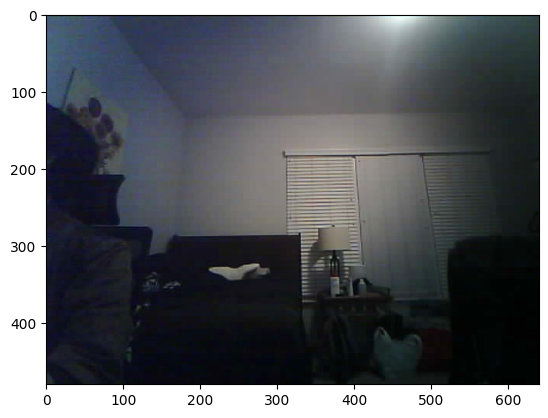

In [6]:
plt.imshow(node.img[:,:,::-1])

In [7]:
def set_params(esp_ip, param, value):
    url = f"http://{esp_ip}/control?var={param}&val={value}"
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Set {param} to {value}")
        return True
    else:
        print(f"Failed to set {param}")
        return False

In [8]:
# esp_ip = "192.168.1.103"
esp_ip = "koh-esp32cam.local"
url = f"http://{esp_ip}/serial"

In [9]:
while True:
    response = requests.get(url)
    if response.text:
        break

In [10]:
response.text

'IMU:32767,32584,5804,-286,-146,-59%us_dist:0.75%voltage:0.00%line_tracker:39,39,39%\r'

In [11]:
sensor_data = {}
for sensor_raw_str in response.text.split('%')[:-1]:
    sensor_name, sensor_data_str = sensor_raw_str.split(':')
    for sensor_data_temp in sensor_data_str.split(','):
        if sensor_name in sensor_data.keys():
            sensor_data[sensor_name].append(sensor_data_temp)
        else:
            sensor_data[sensor_name] = [sensor_data_temp]

In [2]:
UDP_IP = "255.255.255.255"
UDP_PORT = 9750

In [42]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))

print(f"Listening on {UDP_IP}:{UDP_PORT}...")

# while True:
data, addr = sock.recvfrom(128)  # Buffer size
print(f"Received from {addr}: {data}")

Listening on 255.255.255.255:9750...
Received from ('192.168.0.24', 9750): b'IMU:96,136,16320,-51,-1,-97%us_dist:0.6205%voltage:0.00%line_tracker:39,40,39%'


In [5]:
data.decode()

'IMU:-204,44,15768,36,-28,-136%us_dist:0.3384%voltage:0.00%line_tracker:39,40,39%\r'

In [2]:
ESP32_IP = "koh-esp32cam.local"
ESP32_PORT = 9750

In [3]:
def send_cmd(command):
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(command.encode(), (ESP32_IP, ESP32_PORT))
    sock.close()

In [17]:
command = "motor:r,1,0"
send_cmd(command)

In [18]:
command = "motor:l,0,0"
send_cmd(command)

In [3]:
from sensor_msgs.msg import CameraInfo
import numpy as np
from scipy import io
import os

calib_path = os.path.join(
    os.path.expanduser('~'),
    'espcam_calib',
    'espcam_calib_params.mat'
)

In [12]:
msg = CameraInfo()
# calib_data = io.loadmat(calib_path, simplify_cells=True)['data']
# msg.header.frame_id  = 'espcam'
# msg.width            = calib_data['ImageSize'][1]
# msg.height           = calib_data['ImageSize'][0]
# msg.distortion_model = 'plumb_bob'
# msg.d                = [
#     calib_data['RadialDistortion'][0],
#     calib_data['RadialDistortion'][1],
#     calib_data['TangentialDistortion'][0],
#     calib_data['TangentialDistortion'][1],
#     calib_data['RadialDistortion'][2],
# ]
# msg.k                = list(calib_data['K'].ravel())
# msg.r                = np.eye(3).ravel().tolist()
# msg.p                = [
#     calib_data['FocalLength'][0], 0, calib_data['PrincipalPoint'][0], 0,
#     0, calib_data['FocalLength'][1], calib_data['PrincipalPoint'][1], 0,
#     0, 0, 1, 0
# ]

In [13]:
msg

sensor_msgs.msg.CameraInfo(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=0, nanosec=0), frame_id=''), height=0, width=0, distortion_model='', d=[], k=array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), r=array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), p=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), binning_x=0, binning_y=0, roi=sensor_msgs.msg.RegionOfInterest(x_offset=0, y_offset=0, height=0, width=0, do_rectify=False))

In [11]:
msg.k

array([336.25187094,   0.        , 332.32786152,   0.        ,
       335.78814462, 233.21319589,   0.        ,   0.        ,
         1.        ])